# 導入不同策略 根據最新300根k棒產生的買賣序列 進行回測 畫出圖表

,metric
回測K棒數量,10000
總報酬率,394.07
日報酬率,0.3842
最大回撤,-32.21
交易次數,825
勝率,12.24
平均持有K棒數,5.20
平均每筆報酬率,-0.02
平均獲利時報酬,3.87
平均虧損時報酬,-0.56


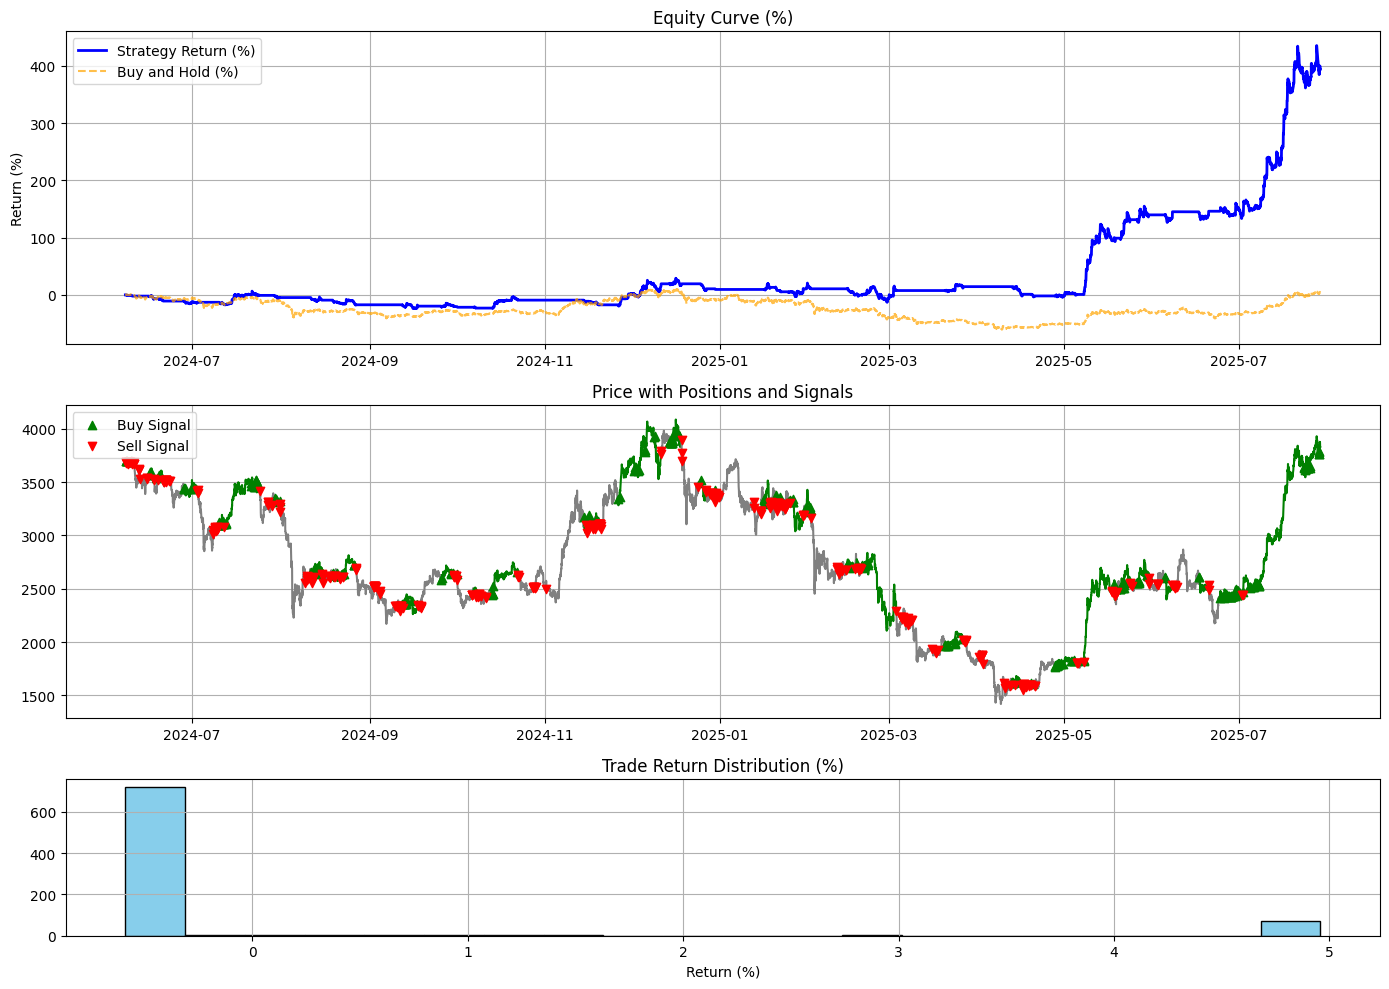

In [28]:
from Technicalindicatorstrategy import vegas
from Backtest.backtest import backtest_signals
from Plot.plot import plot_backtest_result
import pandas as pd
from datetime import datetime
import warnings 
warnings.filterwarnings('ignore')

df_signals = vegas.get_signals('ETHUSDT','1h',datetime.now(),10000)

result = backtest_signals(
    df_signals,
    initial_capital=33, 
    fee_rate = 0.0004,
    leverage = 1, 
    allow_short = False,
    stop_loss = 0.005,       # 停損閾值，例如0.05代表5%
    take_profit = 0.05,     # 停利閾值
    max_hold_bars = 1000)  # 最大持有K棒數

display(pd.DataFrame(result['metric'],index=['metric']).T)
plot_backtest_result(result['fig'])